<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports-and-setup-functions" data-toc-modified-id="Imports-and-setup-functions-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports and setup functions</a></span></li><li><span><a href="#DataLoader-Module" data-toc-modified-id="DataLoader-Module-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>DataLoader Module</a></span><ul class="toc-item"><li><span><a href="#Image-regions" data-toc-modified-id="Image-regions-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Image regions</a></span><ul class="toc-item"><li><span><a href="#Find-interesting-regions-to-test-on" data-toc-modified-id="Find-interesting-regions-to-test-on-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>Find interesting regions to test on</a></span></li><li><span><a href="#Cut-all-data-into-64x64-regions" data-toc-modified-id="Cut-all-data-into-64x64-regions-2.1.2"><span class="toc-item-num">2.1.2&nbsp;&nbsp;</span>Cut all data into 64x64 regions</a></span></li><li><span><a href="#Save-to-.npy-files" data-toc-modified-id="Save-to-.npy-files-2.1.3"><span class="toc-item-num">2.1.3&nbsp;&nbsp;</span>Save to .npy files</a></span></li></ul></li><li><span><a href="#Train-val-test-split" data-toc-modified-id="Train-val-test-split-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Train-val-test split</a></span></li><li><span><a href="#Inputs-and-ends" data-toc-modified-id="Inputs-and-ends-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Inputs and ends</a></span></li><li><span><a href="#Tensors,-DataLoader" data-toc-modified-id="Tensors,-DataLoader-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Tensors, DataLoader</a></span></li><li><span><a href="#Create-DataLoader-for-training-data" data-toc-modified-id="Create-DataLoader-for-training-data-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Create DataLoader for training data</a></span></li></ul></li><li><span><a href="#Model-Module" data-toc-modified-id="Model-Module-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Model Module</a></span><ul class="toc-item"><li><span><a href="#AR1:-linear-mapping" data-toc-modified-id="AR1:-linear-mapping-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>AR1: linear mapping</a></span></li><li><span><a href="#de-Bézenac-et-al,-2019:-CNN-with-warp-mapping" data-toc-modified-id="de-Bézenac-et-al,-2019:-CNN-with-warp-mapping-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>de Bézenac et al, 2019: CNN with warp mapping</a></span><ul class="toc-item"><li><span><a href="#Loss-Function" data-toc-modified-id="Loss-Function-3.2.1"><span class="toc-item-num">3.2.1&nbsp;&nbsp;</span>Loss Function</a></span></li><li><span><a href="#Warp" data-toc-modified-id="Warp-3.2.2"><span class="toc-item-num">3.2.2&nbsp;&nbsp;</span>Warp</a></span></li><li><span><a href="#Model" data-toc-modified-id="Model-3.2.3"><span class="toc-item-num">3.2.3&nbsp;&nbsp;</span>Model</a></span></li><li><span><a href="#Training" data-toc-modified-id="Training-3.2.4"><span class="toc-item-num">3.2.4&nbsp;&nbsp;</span>Training</a></span></li></ul></li></ul></li></ul></div>

# Imports and setup functions

In [21]:
import datetime
import math
import os
import torch

import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import numpy as np
import netCDF4 as nc
import torch.nn as nn
import torch.nn.functional as F

from torch.autograd import Function, Variable
from functools import reduce

In [22]:
def datadir(x):
    return "/projectnb/labci/Lucia/data/" + x

# DataLoader Module

## Train-val-test split

The authors trained on SST data from 2006-2015 and tested on data from 2016-2017. For the IBI reanalysis SST data, we only have from June 5, 2021 to June 23, 2023 (749 days). From these, we will use 80% for training, 10% for validation, and 10% for testing. 

In [23]:
def all_days(files):
    """Helper method to take a list of filenames and return total the number 
    of days represented by the files in the list. 
    
    This method assumes a particular file naming convention that has been used 
    for this project. 
    
    File naming convention: sst_geo_yyyymmdd.nc_region_XX.npy
    
    Parameters
    ----------
    files : list : data file names
    
    Returns
    -------
    delta : int : the number of days represented by the inputted files
    """
    
    files.sort()
    
    first = datetime.datetime.strptime(files[0][8:16], "%Y%m%d").date()
    last = datetime.datetime.strptime(files[len(files)-1][8:16], "%Y%m%d").date()
    
    delta = int((last - first) / datetime.timedelta(days=1))
    
    return delta

def train_val_test_cutoffs(topdir, split):
    """Helper method to create lists of filenames for the train, val, and test
    data splits. Uses the dates in the filenames to determine file order and 
    split cutoffs.
    
    This method assumes a particular file naming convention that has been used 
    for this project. 
    
    File naming convention: sst_geo_yyyymmdd.nc_region_XX.npy
       
    Parameters
    ----------
    topdir : string : the path to the directory holding the data
    split : list : the fractions for each split, eg. [0.8, 0.1, 0.1]
    
    Returns
    -------
    cutoffs : list : date cutoffs for each split
    """
    
    all_files = os.listdir(topdir)
    all_files.sort()
    nfiles = len(all_files)
    ndays = all_days(all_files)
    
    start_date = datetime.datetime.strptime(all_files[0][8:16], "%Y%m%d").date()
    end_date = datetime.datetime.strptime(all_files[nfiles-1][8:16], "%Y%m%d").date()
    
    cutoffs = []
    
    for i in range(3):
        delta = math.floor(ndays*split[i])
        end = start_date + datetime.timedelta(days=delta)
        cutoffs.append(end)
        
        start_date = end
        
    # Because of rounding, some files may have been missed
    # Add these to the test split
    if cutoffs[2] < end_date:
        cutoffs[2] = end_date
    
    return cutoffs

def train_val_test_split_files(topdir, split):
    """Method to split the data in a directory into training, validation, and
    test sets. Uses the helper method train_val_test_cutoffs().
    
    This method assumes a particular file naming convention that has been used 
    for this project. 
    
    File naming convention: sst_geo_yyyymmdd.nc_region_XX.npy
    
    Parameters
    ----------
    topdir : string : the path to the directory holding the data
    split : list : the fractions for each split, eg. [0.8, 0.1, 0.1]
    
    Returns
    -------
    train : list : list of filenames for the train set
    val : list : list of filenames for the validation set
    test : list : list of filenames for the test set
    """
    
    assert len(split) == 3, "Please include a % split for train, validation, and test sets."
    
    cutoffs = train_val_test_cutoffs(topdir, split)
    
    all_files = os.listdir(topdir)
    all_files.sort()
    
    train, val, test = [], [], []
    
    for f in all_files:
        file_date = datetime.datetime.strptime(f[8:16], "%Y%m%d").date()
        
        if file_date <= cutoffs[0]:
            train.append(f)
        elif (file_date > cutoffs[0]) & (file_date <= cutoffs[1]):
            val.append(f)
        else:
            test.append(f)
            
    return train, val, test

In [24]:
def load_data_from_file(filename):
    """Helper method to load a single .npy file."""
    return np.load(datadir("sst_npy/" + filename))


def load_data_from_files(files):
    """Method to load data from a list of .npy files."""
    data = []
    for f in files:
        data.append(load_data_from_file(f))
        
    return np.array(data)

## Inputs and ends

In [25]:
def search_by_region(files, region):
    """Helper method to search a list of files for only those corresponding to
    a desired region. 
    
    This method assumes a particular file naming convention that has been used 
    for this project. 
    
    File naming convention: sst_geo_yyyymmdd.nc_region_XX.npy
    
    Parameters
    ----------
    files : list : list of filenames in which to search
    region : int : desired region
    
    Returns
    -------
    region_files : list : sorted list of matching files
    """
    
    region_files = []
    for fname in files:
        if "region_" + str(region) + ".npy" in fname:
            region_files.append(fname)
            
    region_files.sort()
    
    return region_files

def get_pairs_by_region(files, region, ndays=1):
    """Method to separate data into inputs (X) and ends (y), for example to
    use 4 previous days (ndays=4) to predict the next day. The "pairs" are 
    pairs of (X,y) inputs and ends. This method works on one region at a time.
    
    Parameters
    ----------
    files : list : list of files from which to get pairs
    region : int : desired region
    ndays : int : number of days to use as inputs
    
    Returns
    -------
    inps : np.ndarray : filenames for inputs
    ends : list : filenames for ends
    """
    
    region_files = search_by_region(files, region)
    
    n = len(region_files)
    
    inps = []
    ends = region_files[ndays:]
    
    for i in range(n - ndays):
        inps.append(region_files[i:i+ndays])
    
    return np.array(inps), np.array(ends)

In [26]:
def all_regions(files):
    """Helper method to take a list of filenames and return a list of the 
    unique region numbers. 
    
    This method assumes a particular file naming convention that has been used 
    for this project. 
    
    File naming convention: sst_geo_yyyymmdd.nc_region_XX.npy
    
    Parameters
    ----------
    files : list : data file names
    
    Returns
    -------
    regions : list : list of unique region numbers in the directory
    """
    
    files.sort()
    regions = []
    
    for f in files:
        if "region_" in f:
            
            start_ind = f.find("region_") + len("region_")
            end_ind = f.find(".npy")
            
            reg = f[start_ind:end_ind]
            
            if int(reg) not in regions:
                regions.append(int(reg))
            
        else:
            print("Files in this directory do not match the naming convention.")
    
    regions.sort()
    
    return regions

## Tensors, DataLoader

In [27]:
def create_dataloader(batchsize, files, ndays, dtype=torch.FloatTensor, shuff=True):
    """Method to create a PyTorch DataLoader object from a list of files and
    additional parameters.
    
    Parameters
    ----------
    dtype : torch.dtype : the data type for the DataLoader
    batchsize : int : the desired batchsize for loading data
    files : str : a list of files holding data to put into the DataLoader
    ndays : int : the number of days to use as inputs to predict the next day
    
    Returns
    -------
    loader : torch.utils.data.DataLoader : the DataLoader object
    """
    
    regions = all_regions(files)

    data = []
    ends = []

    for reg in regions:
        reg_pairs = get_pairs_by_region(files, reg, ndays)
        
        for i in range(len(reg_pairs[0])):
            dat = load_data_from_files(reg_pairs[0][i])
            end = load_data_from_file(reg_pairs[1][i])
        
            data.append(dat)
            ends.append(end)
        
    final_data = torch.from_numpy(np.array(data)).type(dtype)
    final_ends = torch.from_numpy(np.array(ends)).type(dtype)
    
    loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(final_data, final_ends),
                                           batch_size=batchsize, shuffle=shuff)
    
    return loader

# Model Module

## de Bézenac et al, 2019: CNN with warp mapping

### Loss Function

The authors used a Charbonnier penality to measure the discrepancy between the predicted next image and the target: 

$\rho(x) = (x + \epsilon)^\frac{1}{\alpha}$

Note that with $\epsilon=0$ and $\alpha=\frac{1}{2}$, we recover the $\textit{l}_2$ norm. 

Additional penalty terms were added to the loss function, specifically to regulate the divergence of the displacement $\omega$ between the prediction and the target, its magnitude, and its smoothness:

$L_t = \underset{x \in \Omega}\Sigma \rho(\hat{I}_{t+1}(x) - I_{t+1}(x)) + \lambda_{div}(\nabla.\omega_t(x))^2 + \lambda_{magn}||\omega_t(x)||^2 + \lambda_{grad}||\nabla \omega_t(x)||^2$

In [28]:
def compute_regloss(F):
    gradient = reduce(np.add, np.gradient(F))
    
    # TODO: try magnitude regularization in norm loss function
    # could also move to inside model class
    divergence = np.array([np.mean(gradient.sum(0)**2)])                         # 1st reg term above
    magnitude  = np.array([np.mean(np.linalg.norm(F, axis=0, ord=2)**2)])        # 2nd reg term above
    smoothness = np.array([np.mean(np.linalg.norm(gradient, axis=0, ord=2)**2)]) # 3rd reg term above
    
    return torch.from_numpy(divergence).type(torch.FloatTensor), torch.from_numpy(magnitude).type(torch.FloatTensor), torch.from_numpy(smoothness).type(torch.FloatTensor)

In [29]:
def charbonnier(x, alpha, eps):
    
    res = torch.mean(torch.pow(x + eps, (1. / alpha)))

    return res

def grad_charbonnier(x, alpha, eps):
    
    res = (1. / alpha)*torch.pow(x + eps, (1. / alpha) - 1)
    
    return res

In [30]:
class Charbonnier_Loss(Function):
    
    @staticmethod
    def forward(ctl, y_pred, y, w, reg, alpha=0.5, eps=0):
        ctl.save_for_backward(y_pred, y) # saves Tensor ctl for future call to backward()
        
        distsq = torch.pow(y_pred - y, 2)
        charb_loss = charbonnier(distsq, alpha, eps)
        
        if reg:
            lambda_div, lambda_magn, lambda_grad = 1, -0.1, 0.4
            divergence, magnitude, smoothness = compute_regloss(w[0,:,:,:].numpy())
            regulariz = lambda_div*divergence + lambda_magn*magnitude + lambda_grad*smoothness
            charb_loss += regulariz[0]
        
        return charb_loss
    
    @staticmethod
    # FIXME: with regularization constants, this is incomplete -> need grad(w) wrt x
    def backward(ctl, alpha=0.5, eps=0):
        y_pred, y = ctl.saved_tensors
        distsq = torch.pow(y_pred - y, 2)

        grad = grad_charbonnier(distsq, alpha, eps)
        
        return grad, None, None, None

In [43]:
def squared_error_loss(y_pred, y): 
    error = torch.sum((y_pred - y)**2, axis=1)
    loss = torch.mean(error)
    return loss

def charbonnier_loss(y_pred, y, alpha=0.5, epsilon=0):
    error = torch.sum((y_pred - y)**2, axis=1)
    loss = torch.mean(torch.pow(error + epsilon, (1. / alpha)))
    return loss

# TODO: add reg terms on W somehow (start with magnitude)

### Warp

The future image is calculated based on a "warp" of the motion field estimate, $\hat{\omega}$, which can be thought of in this application as the wind vector field:

$\hat{I}_{t+1}(x) = \underset{y \in \Omega} \Sigma k(x - \hat{\omega}(x), y) I_t (y)$

where $k(u, v)$ is a radial basis function kernel, or equivalent a 2D Gaussian probability distribution:

$k(x - \hat{\omega}(x), y) = \frac{1}{4 \pi D\Delta t}e^{\frac{-1}{4D \Delta t} ||x - \hat{\omega}(x) - y||^2}$

for diffusion coefficient D and time step value $\Delta t$ between $t$ and $t+1$.

In [32]:
def kernel(distsq, D, dt):
    """Method to implement the k() function or radial basis function kernel 
    described above.
    
    Parameters
    ----------
    distsq : float or torch.FloatTensor : the value of the squared norm of 
                 the distance
    D : float : the diffusion coefficient
    dt : float : the timestep
    
    Returns
    -------
    res : float or torch.FloatTensor: the result of the function
    """
    
    res = torch.exp(-distsq/(4*D*dt))/(4*np.pi*D*dt)
    return res

def kernel_gradient(self, dist, D, dt):
    """Method to implement the gradient of the k() function with respect to 
    the distance.
    
    Parameters
    ----------
    dist : float : the distance
    D : float : the diffusion coefficient
    dt : float : the timestep
    
    Returns
    -------
    res : float : the gradient of the function with respect to the distance
    """
    
    res = dist*torch.exp(-(dist**2).sum(1)/(4*D*dt))/(8*np.pi*D**2*dt**2)
    return res

### Model

In [33]:
def initialize_weights(*models):
    for model in models:
        for module in model.modules():
            
            if isinstance(module, nn.Conv2d) or isinstance(module, nn.ConvTranspose2d) or isinstance(module, nn.Linear):
                
                # He initialization, from He, K. et al, 2015
                nn.init.kaiming_normal_(module.weight)
                if module.bias is not None:
                    module.bias.data.zero_()
                    
            elif isinstance(module, nn.BatchNorm2d):
                module.weight.data.fill_(1)
                module.bias.data.zero_()

In [34]:
class _EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(_EncoderBlock, self).__init__()
        self.cv1 = nn.Conv2d(in_channels, in_channels, kernel_size=3,padding=1)
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.lr1 = nn.LeakyReLU(0.1)
        self.cv2 = nn.Conv2d(in_channels, out_channels, kernel_size=3)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.lr2 = nn.LeakyReLU(0.1)
        self.maxp = nn.MaxPool2d(kernel_size=3, stride=1)
        
    def forward(self, x):
        residual=x
        #print("residual",residual.shape)
        out=self.cv1(x)
        #print("cv1",out.shape)
        out=self.bn1(out)
        #print("bn1",out.shape)
        out=self.lr1(out)
        #print("lr1",out.shape)
        out+=residual
        out=self.cv2(out)
        out=self.bn2(out)
        out=self.lr2(out)
        out=self.maxp(out)
        return out

class _DecoderBlock(nn.Module):
    def __init__(self, in_channels, middle_channels, out_channels):
        super(_DecoderBlock, self).__init__()
        self.cv1 = nn.Conv2d(in_channels, in_channels, kernel_size=3,padding=1)
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.lr1 = nn.LeakyReLU(0.1)
        self.cv2 = nn.Conv2d(in_channels, middle_channels, kernel_size=3)
        self.bn2 = nn.BatchNorm2d(middle_channels) 
        self.lr2 = nn.LeakyReLU(0.1)
        self.tcv = nn.ConvTranspose2d(middle_channels, out_channels, kernel_size=3)
        
    def forward(self, x):
        residual=x
        #print("residual",residual.shape)
        out=self.cv1(x)
        #print("cv1",out.shape)
        out=self.bn1(out)
        #print("bn1",out.shape)
        out=self.lr1(out)
        #print("lr1",out.shape)
        out+=residual
        out=self.cv2(out)
        out=self.bn2(out)
        out=self.lr2(out)
        out=self.tcv(out)
        return out

class _CenterBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(_CenterBlock, self).__init__()
        self.cv1 = nn.Conv2d(in_channels,in_channels , kernel_size=3,padding=1)
        self.bn1 = nn.BatchNorm2d(in_channels)  
        self.lr1 = nn.LeakyReLU(0.1)
        self.cv2 = nn.Conv2d(in_channels, out_channels, kernel_size=3)
        self.bn2 = nn.BatchNorm2d(out_channels) 
        self.lr2 = nn.LeakyReLU(0.1)
        self.tcv = nn.ConvTranspose2d(out_channels, out_channels, kernel_size=3)
        
    def forward(self, x):
        residual=x
        out=self.cv1(x)
        out=self.bn1(out)
        out=self.lr1(out)
        out+=residual
        out=self.cv2(out)
        out=self.bn2(out)
        out=self.lr2(out)
        out=self.tcv(out)
        return out

In [35]:
class CDNN(nn.Module):
    """Class to implement a physics-driven Convolution-Deconvolution Neural 
    Network (CDNN) as described in (de Bezenac et al, 2019). This model 
    takes as input historical image(s) of Sea Surface Temperature (SST)
    data, X, and uses a convolutional neural network (CNN) to estimate the 
    wind vector field W that drives the motion of X. From there, the next 
    image is predicted using a "warping" of the most recent input image and W,
    as if to see how the SST variable evolves with the wind. 
    
    The "warping" in this paper is a radial basis function kernel, or a 
    Gaussian centered in X-W. Other models we will implement later may use a
    different warping scheme. 
    """
    
    def __init__(self, hist=1):
        """Function to construct the model. 
           
           Parameters
           ----------
           hist : int : the number of days of "history" to use for prediction, 
                        default = 1.
        """
        
        super(CDNN, self).__init__()
        
        self.enc1 = _EncoderBlock(hist, 64)  
        self.enc2 = _EncoderBlock(64, 128)
        self.enc3 = _EncoderBlock(128, 256)
        self.enc4 = _EncoderBlock(256, 512)
        self.dec4 = _CenterBlock(512, 386)
        self.dec3 = _DecoderBlock(386+256, 256, 194)
        self.dec2 = _DecoderBlock(194+128, 128, 98)
        self.dec1 = _DecoderBlock(98+64, 64, 2)
        
        self.final = nn.Sequential(nn.Conv2d(2, 2, kernel_size=3),) 
        initialize_weights(self)

        self.hist = hist

    def wind(self, x):
        """Function to estimate the wind vector field from historical input images.
        
        Parameters
        ----------
        x : torch.FloatTensor : the historical input images
        
        Returns
        -------
        wind : torch.FloatTensor : the estimated wind vector field
        """
        
        enc1 = self.enc1(x)
        #print("x",x.shape)
        #print("enc1",enc1.shape)
        enc2 = self.enc2(enc1)
        #print("enc2",enc2.shape)
        enc3 = self.enc3(enc2)
        #print("enc3",enc3.shape)
        enc4 = self.enc4(enc3)
        #print("enc4",enc4.shape)
        dec4 = self.dec4(enc4)
        #print("dec4",dec4.shape)
        
        dec3 = self.dec3(torch.cat([dec4, F.interpolate(enc3, dec4.size()[2:], mode='bilinear')], 1))
        dec2 = self.dec2(torch.cat([dec3, F.interpolate(enc2, dec3.size()[2:], mode='bilinear')], 1))
        dec1 = self.dec1(torch.cat([dec2, F.interpolate(enc1, dec2.size()[2:], mode='bilinear')], 1))
        final = self.final(dec1)
        
        wind = F.interpolate(final, x.size()[2:], mode='bilinear')

        return wind
    
    @staticmethod
    def warp(I, W, hist):
        """Function to compute the warping of the input data and an estimated 
        wind vector field, in order to produce an output predicted image. 
        
        Parameters
        ----------
        I : torch.FloatTensor : the most recent input image to warp
        W : torch.FloatTensor : the estimated wind vector field
        
        Returns
        -------
        warped : torch.FloatTensor : the warped prediction image
        """
        
        D = 0.45
        dt = 1
        
        interval=torch.arange(I.size()[-1]).type(torch.FloatTensor)
        
        x1 = interval[None,:,None,None,None]
        x2 = interval[None,None,:,None,None]
        y1 = interval[None,None,None,:,None]
        y2 = interval[None,None,None,None,:]
        
        # x - wind - y
        distsq = (x1-y1-W[:,0,:,:,None,None])**2+(x2-y2-W[:,1,:,:,None,None])**2         
        mult = I[:, hist-1, None,None,:,:] * kernel(distsq, D, dt)
        warped = mult.sum(4).sum(3)
        
        return warped

    def forward(self, x):
        """Function to execute the forward pass of the model. All of the 
        computations are done in the methods above, so this function 
        simply returns their outputs.
        
        Note: the wind vector field W is returned for use in the 
        regularized loss function later. For simple difference loss 
        functions, returning y_pred is sufficient. 
        
        Parameters
        ----------
        x : torch.FloatTensor : the historical input images
        
        Returns
        -------
        W : torch.FloatTensor : the estimated wind vector field
        y_pred : torch.FloatTensor : the predicted next image
        """
        
        W = self.wind(x)
        y_pred = self.warp(x, W, self.hist) 
        
        return W, y_pred 

## Experiments

### Setup

In [ ]:
class Experiment():
    
    def __init__(self, name, trainset, valset, testset, model, loss_fn, regloss, test_loss, optimizer, examples, outdir):
        self.name = name
        self.train_loader = trainset 
        self.val_loader = valset
        self.test_loader = testset
        self.model = model
        self.loss_fn = loss_fn
        self.regloss = regloss
        self.test_loss = test_loss
        self.optimizer = optimizer
        self.examples = examples
        
        self.train_losses = []
        self.valid_losses = []
        self.test_losses  = []
        
        # Set up a directory for the experiment
        self.dir_setup(outdir)
        
    def dir_setup(self, parent):
        self.outdir = parent + "/" + self.name
        os.mkdir(self.outdir)
        print("Created new directory to save model states and results: " + self.outdir)
    
    def train_loop(self):
        size = len(self.train_loader.dataset)
        # Set the model to training mode - important for batch normalization and dropout layers
        # Unnecessary in this situation but added for best practices
        self.model.train()
    
        losses = []
    
        for batch, (X, y) in enumerate(self.train_loader):
            # Compute prediction and loss
            #X = X.to(device) 
            #y = y.to(device)
            outputs = self.model(X)
            wind = outputs[0]
            y_pred = outputs[1]
            
            if "MSE" or "Err" in self.name:
                loss = self.loss_fn(y_pred, y)
            else:
                loss = self.loss_fn(y_pred, y, wind, self.regloss)
                
            losses.append(loss.item())
        
            print("Step:", batch, "Loss:", loss)
        
            # Backpropagation
            loss.backward()
            self.optimizer.step()
            self.optimizer.zero_grad()
        
        return losses
    
    # TODO: implement cross-validation?
    # example: https://saturncloud.io/blog/how-to-use-kfold-cross-validation-with-dataloaders-in-pytorch/
    def val_loop(self):
        # Set the model to evaluation mode - important for batch normalization and dropout layers
        # Unnecessary in this situation but added for best practices
        self.model.eval()
        losses = []
        num_loops = 0

        # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
        # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
        with torch.no_grad():
            for X, y in self.val_loader:
                #X = X.to(device) 
                #y = y.to(device)
                outputs = self.model(X)
                y_pred = outputs[1]
            
                step_loss = self.loss_fn(y_pred, y).item()
                print("Item:", num_loops, "Loss:", step_loss)
                losses.append(step_loss)
                num_loops += 1

        return losses
    
    def test(self):
        # Set the model to evaluation mode - important for batch normalization and dropout layers
        # Unnecessary in this situation but added for best practices
        self.model.eval()
        losses = []
        num_loops = 0

        # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
        # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
        with torch.no_grad():
            for X, y in self.test_loader:
                #X = X.to(device) 
                #y = y.to(device)
                outputs = self.model(X)
                y_pred = outputs[1]
            
                step_loss = self.test_loss(y_pred, y).item()
                print("Item:", num_loops, "Loss:", step_loss)
                losses.append(step_loss)
                num_loops += 1

        return losses
    
    def save_results(self, losses, fname):
        np.save(fname + ".npy", losses)
    
    def save_model_state(self, epoch):
        torch.save({
            'epoch': epoch,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'loss': self.train_losses,
            }, self.outdir)
        
        print("Saved checkpoint at epoch", epoch)
    
    def run(self, epochs):
        print("Running experiment: " + self.name + "...")
        
        # -------------------- Training -------------------------
        
        print("Training over " + str(epochs) + " epochs...")
                
        for t in range(epochs):
            print(f"Epoch {t+1}\n-------------------------------")
            
            start = datetime.now()
            epoch_losses = self.train_loop()
            
            fname = self.outdir + "/train_epoch_" + str(t)
            self.save_results(epoch_losses, fname)
            
            epoch_mean = np.round(np.mean(epoch_losses), 5)
            
            print("Mean:", epoch_mean)
            print("Runtime:", datetime.now() - start)
            
            self.train_losses.append(epoch_mean)
            
            if t % 100 == 0:
                self.save_model_state(t)
        
        self.plot_loss(self.train_losses, "Training Loss", "Epoch", ["train"])
        
        # -------------------- Validation ------------------------
        # -------------------- Testing ---------------------------
    
    # TODO: implement with the "interesting" examples found earlier
    def visualize_examples(self):
        # "Interesting" regions were 3, 22, 29, 44 -> each 64x64
        # Need to figure out where each region went in the DataLoader & how to index them
        # Or, what if we don't need them to be in the DataLoader? Just load the arr.s & input thru constructor?
        pass
    
    def plot_loss(self, loss_to_plot, title, xlab, legend_items):
        plt.plot(loss_to_plot)
        plt.title(self.name + " " + title)
        
        plt.ylabel("Loss")
        plt.xlabel(xlab)
        plt.legend(legend_items, loc="upper left")
    
        plt.show()

### Dataloaders

720
3552
31680
44


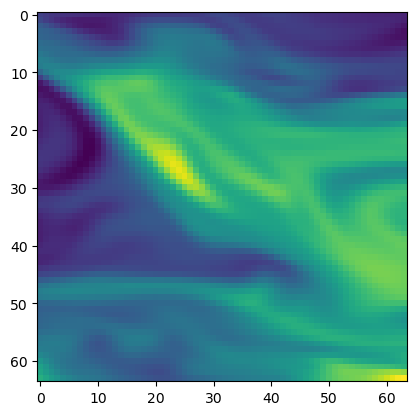

In [37]:
torch.manual_seed(42)

split = train_val_test_split_files(datadir("sst_npy/"), [0.02, 0.1, 0.1]) # using small amount for now, to test

train_split = split[0]
val_split   = split[1]
test_split  = split[2]

# Total number of files in each split
print(len(train_split))
print(len(val_split))
print(len(test_split))

# For faster training, try larger batchsize
training_loader = create_dataloader(batchsize=12, files=train_split, ndays=4, shuff=True)
#val_loader = create_dataloader(batchsize=12, files=val_split, ndays=4, shuff=True)

# Total number of batches in the loader
print(len(training_loader))

train_first, train_next = next(iter(training_loader)) 
plt.imshow(train_first[0][0])

In [38]:
try:
    os.mkdir("/projectnb/labci/Lucia/rainfall-pde-ml/experiments/" + str(datetime.date.today()))
except FileExistsError as e:
    print("Already ran experiments today.")
finally:
    path = "/projectnb/labci/Lucia/rainfall-pde-ml/experiments/" + str(datetime.date.today())

### Training with MSELoss

In [ ]:
torch.manual_seed(42)

net0 = CDNN(hist=4)
optim = torch.optim.Adam(net0.parameters(), lr=1e-3)

exp0 = Experiment(name="Bezenac_MSE_small_3",                           # de Bezenac model, trained on MSE Loss
                  trainset=training_loader, valset=None, testset=None,  # data loaders
                  model=net0,                                           # model with 4 days of history
                  loss_fn=nn.MSELoss(reduction="mean"),                 # loss function for training
                  regloss=False,                                        # whether to regularize the training loss  
                  test_loss=nn.MSELoss(reduction="mean"),               # loss function for testing
                  optimizer=optim,
                  examples=None,
                  outdir=path)

exp0.run(epochs=5)

Created new directory to save model states and results: /projectnb/labci/Lucia/rainfall-pde-ml/experiments/2023-09-15/Bezenac_MSE_small_3
Running experiment: Bezenac_MSE_small_3...
Training over 5 epochs...
Epoch 1
-------------------------------
Step: 0 Loss: tensor(71.3972, grad_fn=<MseLossBackward0>)
Step: 1 Loss: tensor(109.3598, grad_fn=<MseLossBackward0>)
Step: 2 Loss: tensor(39.6824, grad_fn=<MseLossBackward0>)
Step: 3 Loss: tensor(56.3631, grad_fn=<MseLossBackward0>)
Step: 4 Loss: tensor(60.0565, grad_fn=<MseLossBackward0>)
Step: 5 Loss: tensor(36.2472, grad_fn=<MseLossBackward0>)


### Training with (Unregularized) Charbonnier Loss

Created new directory to save model states and results: /projectnb/labci/Lucia/rainfall-pde-ml/experiments/2023-09-15/Bezenac_Charb_small_3
Running experiment: Bezenac_Charb_small_3...
Training over 5 epochs...
Epoch 1
-------------------------------
Step: 0 Loss: tensor(18999658., grad_fn=<MeanBackward0>)
Step: 1 Loss: tensor(69332480., grad_fn=<MeanBackward0>)
Step: 2 Loss: tensor(30322246., grad_fn=<MeanBackward0>)
Step: 3 Loss: tensor(19650786., grad_fn=<MeanBackward0>)
Step: 4 Loss: tensor(23429334., grad_fn=<MeanBackward0>)
Step: 5 Loss: tensor(6356429.5000, grad_fn=<MeanBackward0>)
Step: 6 Loss: tensor(17030198., grad_fn=<MeanBackward0>)
Step: 7 Loss: tensor(2062093.5000, grad_fn=<MeanBackward0>)
Step: 8 Loss: tensor(3158114.7500, grad_fn=<MeanBackward0>)
Step: 9 Loss: tensor(1782738.8750, grad_fn=<MeanBackward0>)
Step: 10 Loss: tensor(941032.1875, grad_fn=<MeanBackward0>)
Step: 11 Loss: tensor(464825.0938, grad_fn=<MeanBackward0>)
Step: 12 Loss: tensor(1899194., grad_fn=<MeanBa

Step: 2 Loss: tensor(1201.5653, grad_fn=<MeanBackward0>)
Step: 3 Loss: tensor(594.3157, grad_fn=<MeanBackward0>)
Step: 4 Loss: tensor(1371.3224, grad_fn=<MeanBackward0>)
Step: 5 Loss: tensor(4455.9126, grad_fn=<MeanBackward0>)
Step: 6 Loss: tensor(486.5388, grad_fn=<MeanBackward0>)
Step: 7 Loss: tensor(966.7439, grad_fn=<MeanBackward0>)
Step: 8 Loss: tensor(839.6509, grad_fn=<MeanBackward0>)
Step: 9 Loss: tensor(632.9714, grad_fn=<MeanBackward0>)
Step: 10 Loss: tensor(642.0200, grad_fn=<MeanBackward0>)
Step: 11 Loss: tensor(1354.6632, grad_fn=<MeanBackward0>)
Step: 12 Loss: tensor(1190.2474, grad_fn=<MeanBackward0>)
Step: 13 Loss: tensor(537.4678, grad_fn=<MeanBackward0>)
Step: 14 Loss: tensor(1703.9889, grad_fn=<MeanBackward0>)
Step: 15 Loss: tensor(1787.1489, grad_fn=<MeanBackward0>)
Step: 16 Loss: tensor(769.7100, grad_fn=<MeanBackward0>)
Step: 17 Loss: tensor(1842.5006, grad_fn=<MeanBackward0>)
Step: 18 Loss: tensor(448.9977, grad_fn=<MeanBackward0>)
Step: 19 Loss: tensor(884.3109,

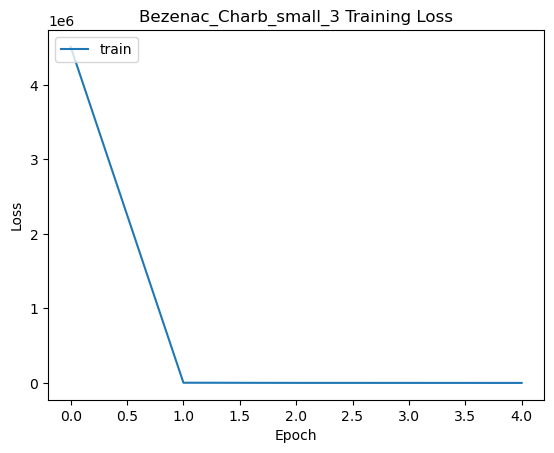

In [44]:
net1 = CDNN(hist=4)
optim = torch.optim.Adam(net1.parameters(), lr=1e-3)

exp1 = Experiment(name="Bezenac_Charb_small_3",                         # de Bezenac model, trained on Charb Loss
                  trainset=training_loader, valset=None, testset=None,  # data loaders
                  model=net1,                                           # model with 4 days of history
                  loss_fn=charbonnier_loss,                             # loss function for training
                  regloss=False,                                        # whether to regularize the training loss 
                  test_loss=nn.MSELoss(reduction="mean"),               # loss function for testing
                  optimizer=optim,
                  examples=None,
                  outdir=path)

exp1.run(epochs=5)

### Training with (Regularized) Charbonnier Loss

In [41]:
net2 = CDNN(hist=4)
optim = torch.optim.Adam(net2.parameters(), lr=1e-3)

exp2 = Experiment(name="Bezenac_CharbReg_small_2",                      # de Bezenac model, trained on Regularized Charb Loss
                  trainset=training_loader, valset=None, testset=None,  # data loaders
                  model=net2,                                           # model with 4 days of history
                  loss_fn=Charbonnier_Loss.apply,                       # loss function for training
                  regloss=True,                                         # whether to regularize the training loss 
                  test_loss=nn.MSELoss(reduction="mean"),               # loss function for testing
                  optimizer=optim,
                  examples=None,
                  outdir=path)

exp2.run(epochs=5)

Created new directory to save model states and results: /projectnb/labci/Lucia/rainfall-pde-ml/experiments/2023-09-15/Bezenac_CharbReg_small_2
Running experiment: Bezenac_CharbReg_small_2...
Training over 5 epochs...
Epoch 1
-------------------------------


TypeError: forward() missing 2 required positional arguments: 'w' and 'reg'

### Training with Squared Error Loss

Created new directory to save model states and results: /projectnb/labci/Lucia/rainfall-pde-ml/experiments/2023-09-15/Bezenac_SqErr_small_0
Running experiment: Bezenac_SqErr_small_0...
Training over 5 epochs...
Epoch 1
-------------------------------
Step: 0 Loss: tensor(4217.4121, grad_fn=<MeanBackward0>)
Step: 1 Loss: tensor(8013.2891, grad_fn=<MeanBackward0>)
Step: 2 Loss: tensor(2224.2229, grad_fn=<MeanBackward0>)
Step: 3 Loss: tensor(4523.1372, grad_fn=<MeanBackward0>)
Step: 4 Loss: tensor(3231.8889, grad_fn=<MeanBackward0>)
Step: 5 Loss: tensor(1050.1475, grad_fn=<MeanBackward0>)
Step: 6 Loss: tensor(810.1934, grad_fn=<MeanBackward0>)
Step: 7 Loss: tensor(525.2222, grad_fn=<MeanBackward0>)
Step: 8 Loss: tensor(435.0779, grad_fn=<MeanBackward0>)
Step: 9 Loss: tensor(598.0999, grad_fn=<MeanBackward0>)
Step: 10 Loss: tensor(396.8212, grad_fn=<MeanBackward0>)
Step: 11 Loss: tensor(151.8920, grad_fn=<MeanBackward0>)
Step: 12 Loss: tensor(159.2534, grad_fn=<MeanBackward0>)
Step: 13 Los

Step: 14 Loss: tensor(2.8350, grad_fn=<MeanBackward0>)
Step: 15 Loss: tensor(4.0220, grad_fn=<MeanBackward0>)
Step: 16 Loss: tensor(4.5661, grad_fn=<MeanBackward0>)
Step: 17 Loss: tensor(3.6186, grad_fn=<MeanBackward0>)
Step: 18 Loss: tensor(4.1965, grad_fn=<MeanBackward0>)
Step: 19 Loss: tensor(5.8347, grad_fn=<MeanBackward0>)
Step: 20 Loss: tensor(2.9659, grad_fn=<MeanBackward0>)
Step: 21 Loss: tensor(1.9482, grad_fn=<MeanBackward0>)
Step: 22 Loss: tensor(2.4295, grad_fn=<MeanBackward0>)
Step: 23 Loss: tensor(4.8530, grad_fn=<MeanBackward0>)
Step: 24 Loss: tensor(4.1803, grad_fn=<MeanBackward0>)
Step: 25 Loss: tensor(4.6053, grad_fn=<MeanBackward0>)
Step: 26 Loss: tensor(5.2404, grad_fn=<MeanBackward0>)
Step: 27 Loss: tensor(2.3982, grad_fn=<MeanBackward0>)
Step: 28 Loss: tensor(2.7741, grad_fn=<MeanBackward0>)
Step: 29 Loss: tensor(6.5655, grad_fn=<MeanBackward0>)
Step: 30 Loss: tensor(3.7174, grad_fn=<MeanBackward0>)
Step: 31 Loss: tensor(5.4605, grad_fn=<MeanBackward0>)
Step: 32 L

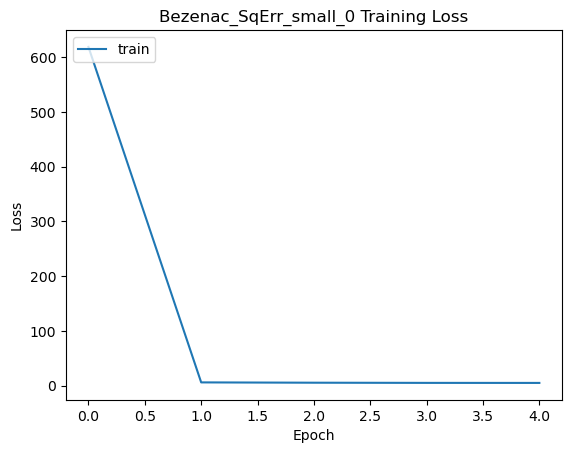

In [40]:
net3 = CDNN(hist=4)
optim = torch.optim.Adam(net3.parameters(), lr=1e-3)

exp3 = Experiment(name="Bezenac_SqErr_small_0",                         # de Bezenac model, trained on err^2 Loss
                  trainset=training_loader, valset=None, testset=None,  # data loaders
                  model=net3,                                           # model with 4 days of history
                  loss_fn=squared_error_loss,                           # loss function for training
                  regloss=False,                                        # whether to regularize the training loss 
                  test_loss=nn.MSELoss(reduction="mean"),               # loss function for testing
                  optimizer=optim,
                  examples=None,
                  outdir=path)

exp3.run(epochs=5)